In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report,roc_auc_score,roc_curve,accuracy_score,auc,confusion_matrix
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from pytorch_tabnet.tab_model import TabNetClassifier
import joblib
from joblib import parallel_backend


In [3]:
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

Exploratory Data Analysis

In [4]:
telco=pd.read_csv('Churn.csv')
telco.head()


,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Churn,Intl_Plan,Vmail_Plan,...,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,State,Area_Code,Phone
0,128,25,265.1,197.4,244.7,10.0,1,no,no,yes,...,45.07,99,16.78,91,11.01,3,2.70,KS,415,382-4657
1,107,26,161.6,195.5,254.4,13.7,1,no,no,yes,...,27.47,103,16.62,103,11.45,3,3.70,OH,415,371-7191
2,137,0,243.4,121.2,162.6,12.2,0,no,no,no,...,41.38,110,10.30,104,7.32,5,3.29,NJ,415,358-1921
3,84,0,299.4,61.9,196.9,6.6,2,no,yes,no,...,50.90,88,5.26,89,8.86,7,1.78,OH,408,375-9999
4,75,0,166.7,148.3,186.9,10.1,3,no,yes,no,...,28.34,122,12.61,121,8.41,3,2.73,OK,415,330-6626


In [5]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3333 entries, 0 to 3332
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Account_Length  3333 non-null   int64  
 1   Vmail_Message   3333 non-null   int64  
 2   Day_Mins        3333 non-null   float64
 3   Eve_Mins        3333 non-null   float64
 4   Night_Mins      3333 non-null   float64
 5   Intl_Mins       3333 non-null   float64
 6   CustServ_Calls  3333 non-null   int64  
 7   Churn           3333 non-null   object 
 8   Intl_Plan       3333 non-null   object 
 9   Vmail_Plan      3333 non-null   object 
 10  Day_Calls       3333 non-null   int64  
 11  Day_Charge      3333 non-null   float64
 12  Eve_Calls       3333 non-null   int64  
 13  Eve_Charge      3333 non-null   float64
 14  Night_Calls     3333 non-null   int64  
 15  Night_Charge    3333 non-null   float64
 16  Intl_Calls      3333 non-null   int64  
 17  Intl_Charge     3333 non-null   f

In [6]:
telco['Churn'].value_counts()

no     2850
yes     483
Name: Churn, dtype: int64

In [7]:
print(telco.groupby('Churn')['CustServ_Calls','Vmail_Message'].mean())
print(telco.groupby('Churn')['CustServ_Calls','Vmail_Message'].std())

       CustServ_Calls  Vmail_Message
Churn                               
no           1.449825       8.604561
yes          2.229814       5.115942
       CustServ_Calls  Vmail_Message
Churn                               
no           1.163883      13.913125
yes          1.853275      11.860138


In [8]:
#pd.set_option('display.max_rows', None)
#pd.reset_option('^display.', silent=True)
telco.groupby('State')['Churn'].value_counts()

State  Churn
AK     no       49
       yes       3
AL     no       72
       yes       8
AR     no       44
                ..
WI     yes       7
WV     no       96
       yes      10
WY     no       68
       yes       9
Name: Churn, Length: 102, dtype: int64

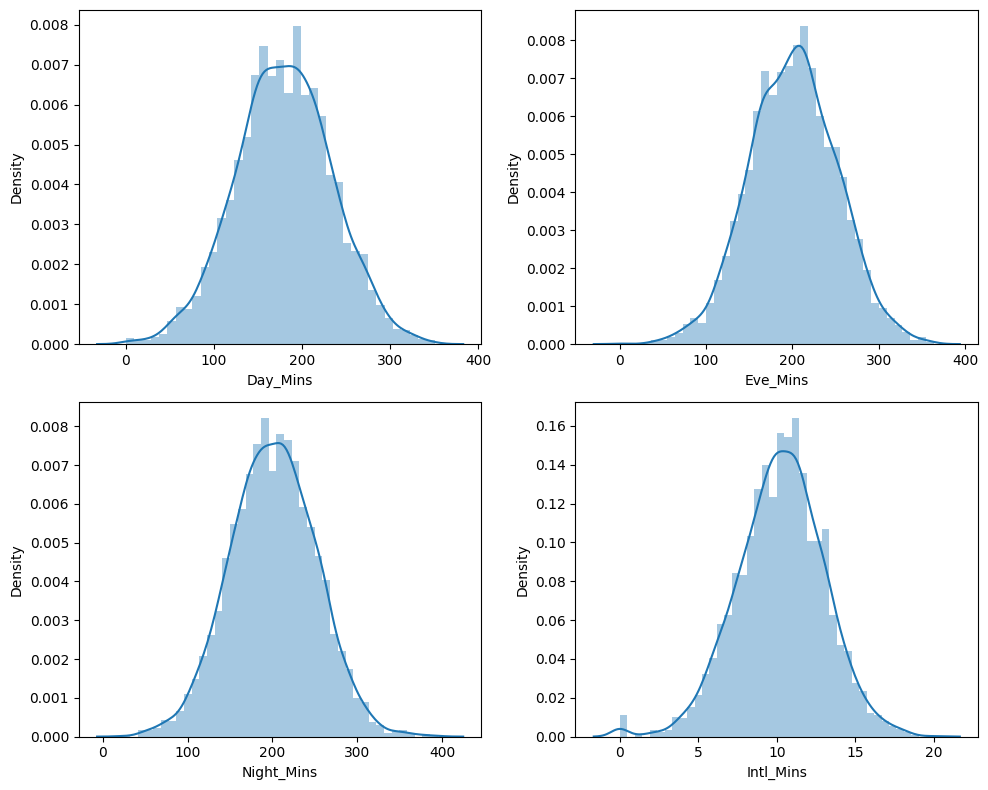

In [9]:
fig,axs=plt.subplots(2,2,figsize=(10,8))
sns.distplot(telco['Day_Mins'],ax=axs[0,0])
sns.distplot(telco['Eve_Mins'],ax=axs[0,1])
sns.distplot(telco['Night_Mins'],ax=axs[1,0])
sns.distplot(telco['Intl_Mins'],ax=axs[1,1])


plt.tight_layout()
plt.show()

<Axes: xlabel='Churn', ylabel='CustServ_Calls'>

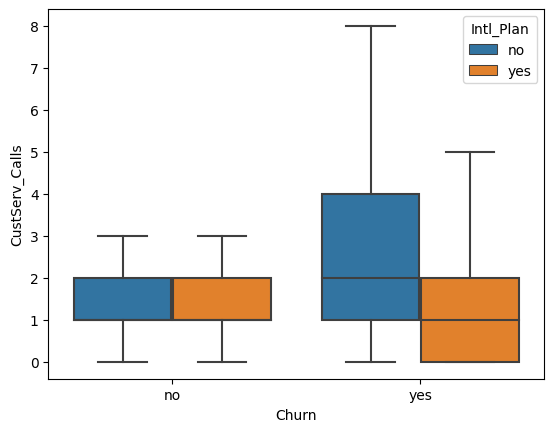

In [10]:
sns.boxplot(x = 'Churn',
            y = 'CustServ_Calls',
            data = telco,
            sym = "",
            hue = "Intl_Plan")

Preprocessing

In [11]:
telco['Vmail_Plan'].replace(['no','yes'],[0,1],inplace=True)
telco['Intl_Plan'].replace(['no','yes'],[0,1],inplace=True)
telco['Churn'].replace(['no','yes'],[0,1],inplace=True)
telco[['Vmail_Plan','Churn','Intl_Plan']].head()

,Vmail_Plan,Churn,Intl_Plan
0,1,0,0
1,1,0,0
2,0,0,0
3,0,0,1
4,0,0,1


In [ ]:
telco_state=pd.get_dummies(telco['State'],drop_first=True)
telco_state.head()

In [13]:
Scaler=StandardScaler()
telco_scaled=Scaler.fit_transform(telco[['Night_Mins','Intl_Calls']])
telco_scaled=pd.DataFrame(telco_scaled,columns=['Night_Mins','Intl_Calls'])
telco_scaled.describe() 

,Night_Mins,Intl_Calls
count,3.333000e+03,3.333000e+03
mean,7.887813e-17,-8.527366e-18
std,1.000150e+00,1.000150e+00
min,-3.513648e+00,-1.820289e+00
25%,-6.698545e-01,-6.011951e-01
50%,6.485803e-03,-1.948306e-01
75%,6.808485e-01,6.178983e-01
max,3.839081e+00,6.307001e+00


In [14]:
telco.drop(['Area_Code','Phone','State'],axis=1,inplace=True)
telco.columns

Index(['Account_Length', 'Vmail_Message', 'Day_Mins', 'Eve_Mins', 'Night_Mins',
       'Intl_Mins', 'CustServ_Calls', 'Churn', 'Intl_Plan', 'Vmail_Plan',
       'Day_Calls', 'Day_Charge', 'Eve_Calls', 'Eve_Charge', 'Night_Calls',
       'Night_Charge', 'Intl_Calls', 'Intl_Charge'],
      dtype='object')

In [15]:
#creating new features
telco['Avg_Night_Calls'] = telco['Night_Mins']/telco['Night_Calls']
telco['Avg_Night_Calls'].head()

0    2.689011
1    2.469903
2    1.563462
3    2.212360
4    1.544628
Name: Avg_Night_Calls, dtype: float64

In [16]:
#0              91             23     232.4     186.0       190.5  ...       15.81          128          8.57           3         3.32
telco.dtypes

Account_Length       int64
Vmail_Message        int64
Day_Mins           float64
Eve_Mins           float64
Night_Mins         float64
Intl_Mins          float64
CustServ_Calls       int64
Churn                int64
Intl_Plan            int64
Vmail_Plan           int64
Day_Calls            int64
Day_Charge         float64
Eve_Calls            int64
Eve_Charge         float64
Night_Calls          int64
Night_Charge       float64
Intl_Calls           int64
Intl_Charge        float64
Avg_Night_Calls    float64
dtype: object

0    2850
1     483
Name: Churn, dtype: int64


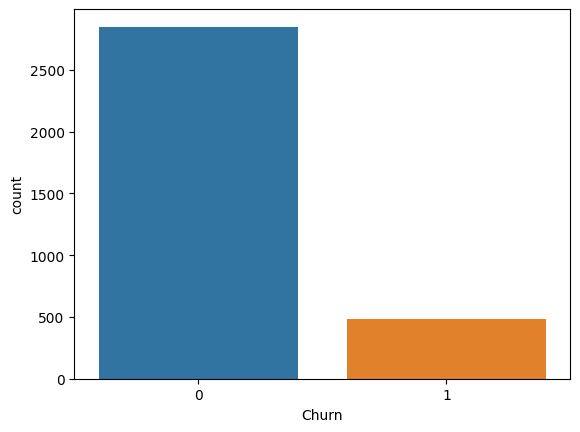

In [17]:
#checking class imbalance
print(telco['Churn'].value_counts())
sns.countplot(x='Churn',data=telco)
plt.show()

In [18]:
#splitting features and target
X=telco.drop('Churn',axis=1)
y=telco['Churn']

In [19]:
#Oversampling the minority class Using SMOTE
smote=SMOTE(sampling_strategy='auto',random_state=42)
X_resampled,y_resampled=smote.fit_resample(X,y)


In [20]:
#standardizing the features
countinuous_features=['Account_Length','Vmail_Message','Day_Mins','Eve_Mins','Night_Mins','Intl_Mins','CustServ_Calls','Avg_Night_Calls','Day_Calls','Day_Charge','Eve_Calls','Eve_Charge','Night_Calls','Night_Charge','Intl_Calls','Intl_Charge']
X_countinuous=X_resampled[countinuous_features]
X_countinuous_scaled=Scaler.fit_transform(X_countinuous)
X_resampled[countinuous_features]=X_countinuous_scaled

In [21]:
X_resampled.head()

,Account_Length,Vmail_Message,Day_Mins,Eve_Mins,Night_Mins,Intl_Mins,CustServ_Calls,Intl_Plan,Vmail_Plan,Day_Calls,Day_Charge,Eve_Calls,Eve_Charge,Night_Calls,Night_Charge,Intl_Calls,Intl_Charge,Avg_Night_Calls
0,0.694089,1.498116,1.206222,-0.173222,0.886697,-0.174042,-0.481201,0,1,0.466856,1.206462,-0.068586,-0.173028,-0.474084,0.885899,-0.509113,-0.174819,0.874374
1,0.146936,1.579511,-0.488247,-0.211137,1.089134,1.246298,-0.481201,0,1,1.135947,-0.488486,0.144926,-0.210592,0.171416,1.089950,-0.509113,1.246976,0.546893
2,0.928584,-0.536747,0.850957,-1.693812,-0.826711,0.670484,-1.181085,0,0,0.672730,0.851101,0.518571,-1.694356,0.225208,-0.825344,0.342771,0.664040,-0.807882
3,-0.452327,-0.536747,1.767771,-2.877158,-0.110878,-1.479218,0.218683,1,0,-1.540417,1.767913,-0.655743,-2.877612,-0.581667,-0.111167,1.194655,-1.482870,0.161966
4,-0.686822,-0.536747,-0.404752,-1.153025,-0.319576,-0.135654,0.918567,1,0,0.621261,-0.404701,1.159106,-1.152031,1.139666,-0.319855,-0.509113,-0.132165,-0.836031


In [22]:
#splitting the data into train and test
X_train,X_test,y_train,y_test=train_test_split(X_resampled,y_resampled,test_size=0.3,random_state=42)

In [23]:
#Test Different Models Using RandomizedSearchCV

models={
    'DesisionTree':(DecisionTreeClassifier(),{'max_depth':[None,5,10,15],'min_samples_split':[2,5,10,15],'min_samples_leaf':[1,2,5,10]}),
    'RandomForest':(RandomForestClassifier(),{'n_estimators':[50,100,150,200],'max_depth':[None,5,10,15],'min_samples_split':[5,10,15],'min_samples_leaf':[2,5,10]}),
    'SVC':(SVC(probability=True),{'kernel':['linear','rbf'],'C':[0.1,1,10,100],'gamma':[0.1,1,10,100]}),
    'XGBoost':(XGBClassifier(),{'n_estimators':[50,100,150,200],'max_depth':[None,5,10,15],'learning_rate':[0.01,0.1,1,10],'colsample_bytree':[0.8,0.9,1.0]}),
    'LightGBM':(LGBMClassifier(),{'n_estimators':[50,100,150,200],'max_depth':[None,5,10,15],'learning_rate':[0.01,0.1,1,10],'colsample_bytree':[0.8,0.9,1.0]}),  
}

best_model={}
with parallel_backend('threading',n_jobs=-1): #n_jobs=-1 means use all the cores
    for model_name,(model,params)in models.items():
        random_search=RandomizedSearchCV(
            model,
            param_distributions=params,
            n_iter=10,
            cv=5,
            scoring='accuracy',
            n_jobs=-1,
            verbose=2
        )
        random_search.fit(X_train,y_train)
        best_model[model_name]=random_search.best_estimator_

for model_name,model in best_model.items():
    print(f"Model {model_name}, Score {model.score(X_test,y_test)}")


Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=1, min_samples_split=10; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=5, min_samples_leaf=2, min_samples_split=2; total time=   0.0s
[CV] END max_depth=10, min_samples_leaf=10, min_samples_split=10; total time=   0.0s
[CV] END max_depth=10, min_sa

In [24]:
#Using TabNetClassifier
tabnet=TabNetClassifier()
params={'n_d': [8,16,32],'n_a':[8,16,32],'n_steps':[3,5,10],'gamma':[1.3,1.5,1.7],'lambda_sparse':[0.0001,0.0005,0.001]}

random_tabnet=RandomizedSearchCV(
    tabnet,
    params,
    cv=5,
    scoring='accuracy',
    verbose=1,
    n_jobs=-1,
    n_iter=10
)
random_tabnet.fit(X_train.values,y_train.values)
print("Best Parameters",random_tabnet.best_params_)
print("Best model",random_tabnet.best_estimator_)
yt_pred=random_tabnet.best_estimator_.predict(X_test.values)
print("Accuracy",accuracy_score(y_test.values,yt_pred))


# tabnet.fit(X_train.values,y_train.values,
#            eval_set=[(X_test.values,y_test.values)],
#            patience=10,max_epochs=50,eval_metric=['accuracy'])
# tabnet_pred=tabnet.predict(X_test.values)
# print(accuracy_score(y_test.values,tabnet_pred))

Fitting 5 folds for each of 10 candidates, totalling 50 fits
epoch 0  | loss: 0.82116 |  0:00:00s
epoch 1  | loss: 0.65998 |  0:00:00s
epoch 2  | loss: 0.5867  |  0:00:01s
epoch 3  | loss: 0.53929 |  0:00:01s
epoch 4  | loss: 0.51338 |  0:00:02s
epoch 5  | loss: 0.49105 |  0:00:02s
epoch 6  | loss: 0.46353 |  0:00:03s
epoch 7  | loss: 0.44191 |  0:00:03s
epoch 8  | loss: 0.4343  |  0:00:04s
epoch 9  | loss: 0.40882 |  0:00:04s
epoch 10 | loss: 0.39996 |  0:00:05s
epoch 11 | loss: 0.39787 |  0:00:05s
epoch 12 | loss: 0.38014 |  0:00:06s
epoch 13 | loss: 0.3767  |  0:00:06s
epoch 14 | loss: 0.37805 |  0:00:06s
epoch 15 | loss: 0.3792  |  0:00:07s
epoch 16 | loss: 0.36422 |  0:00:07s
epoch 17 | loss: 0.34996 |  0:00:08s
epoch 18 | loss: 0.34761 |  0:00:08s
epoch 19 | loss: 0.34582 |  0:00:08s
epoch 20 | loss: 0.33119 |  0:00:09s
epoch 21 | loss: 0.34128 |  0:00:09s
epoch 22 | loss: 0.33143 |  0:00:10s
epoch 23 | loss: 0.31827 |  0:00:10s
epoch 24 | loss: 0.31351 |  0:00:11s
epoch 25 | los

In [33]:
best_model['Tabnet']=random_tabnet.best_estimator_
best_model

{'DesisionTree': DecisionTreeClassifier(),
 'RandomForest': RandomForestClassifier(min_samples_leaf=2, min_samples_split=5,
                        n_estimators=200),
 'SVC': SVC(C=100, gamma=1, probability=True),
 'XGBoost': XGBClassifier(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bynode=None,
               colsample_bytree=0.9, device=None, early_stopping_rounds=None,
               enable_categorical=False, eval_metric=None, feature_types=None,
               gamma=None, grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=15, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               multi_strategy=None, n_estimators=200, n_jobs=None,
               num_parallel_tree=None, random_state=None, ...),
 'LightGBM':

In [25]:
#Evaluating best model (SVC) on test data
print(f"Best parametes for SVC Model={best_model['SVC']}")
y_pred=best_model['SVC'].predict(X_test)


#classification report
print(classification_report(y_test,y_pred))




Best parametes for SVC Model=SVC(C=100, gamma=1, probability=True)


              precision    recall  f1-score   support

           0       0.90      1.00      0.95       882
           1       1.00      0.88      0.94       828

    accuracy                           0.94      1710
   macro avg       0.95      0.94      0.94      1710
weighted avg       0.95      0.94      0.94      1710



In [35]:
#printing classing report for all the models
for model_name,model in best_model.items():
    print(f"Classification report for {model_name}")
    if model_name!='Tabnet':     
        y_pred=model.predict(X_test)
        print(classification_report(y_test,y_pred))
    else:
        y_pred=model.predict(X_test.values)
        print(classification_report(y_test.values,y_pred))

Classification for DesisionTree
              precision    recall  f1-score   support

           0       0.87      0.83      0.85       882
           1       0.83      0.87      0.85       828

    accuracy                           0.85      1710
   macro avg       0.85      0.85      0.85      1710
weighted avg       0.85      0.85      0.85      1710

Classification for RandomForest
              precision    recall  f1-score   support

           0       0.90      0.95      0.93       882
           1       0.95      0.89      0.92       828

    accuracy                           0.92      1710
   macro avg       0.92      0.92      0.92      1710
weighted avg       0.92      0.92      0.92      1710

Classification for SVC
              precision    recall  f1-score   support

           0       0.90      1.00      0.95       882
           1       1.00      0.88      0.94       828

    accuracy                           0.94      1710
   macro avg       0.95      0.94      0.

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).


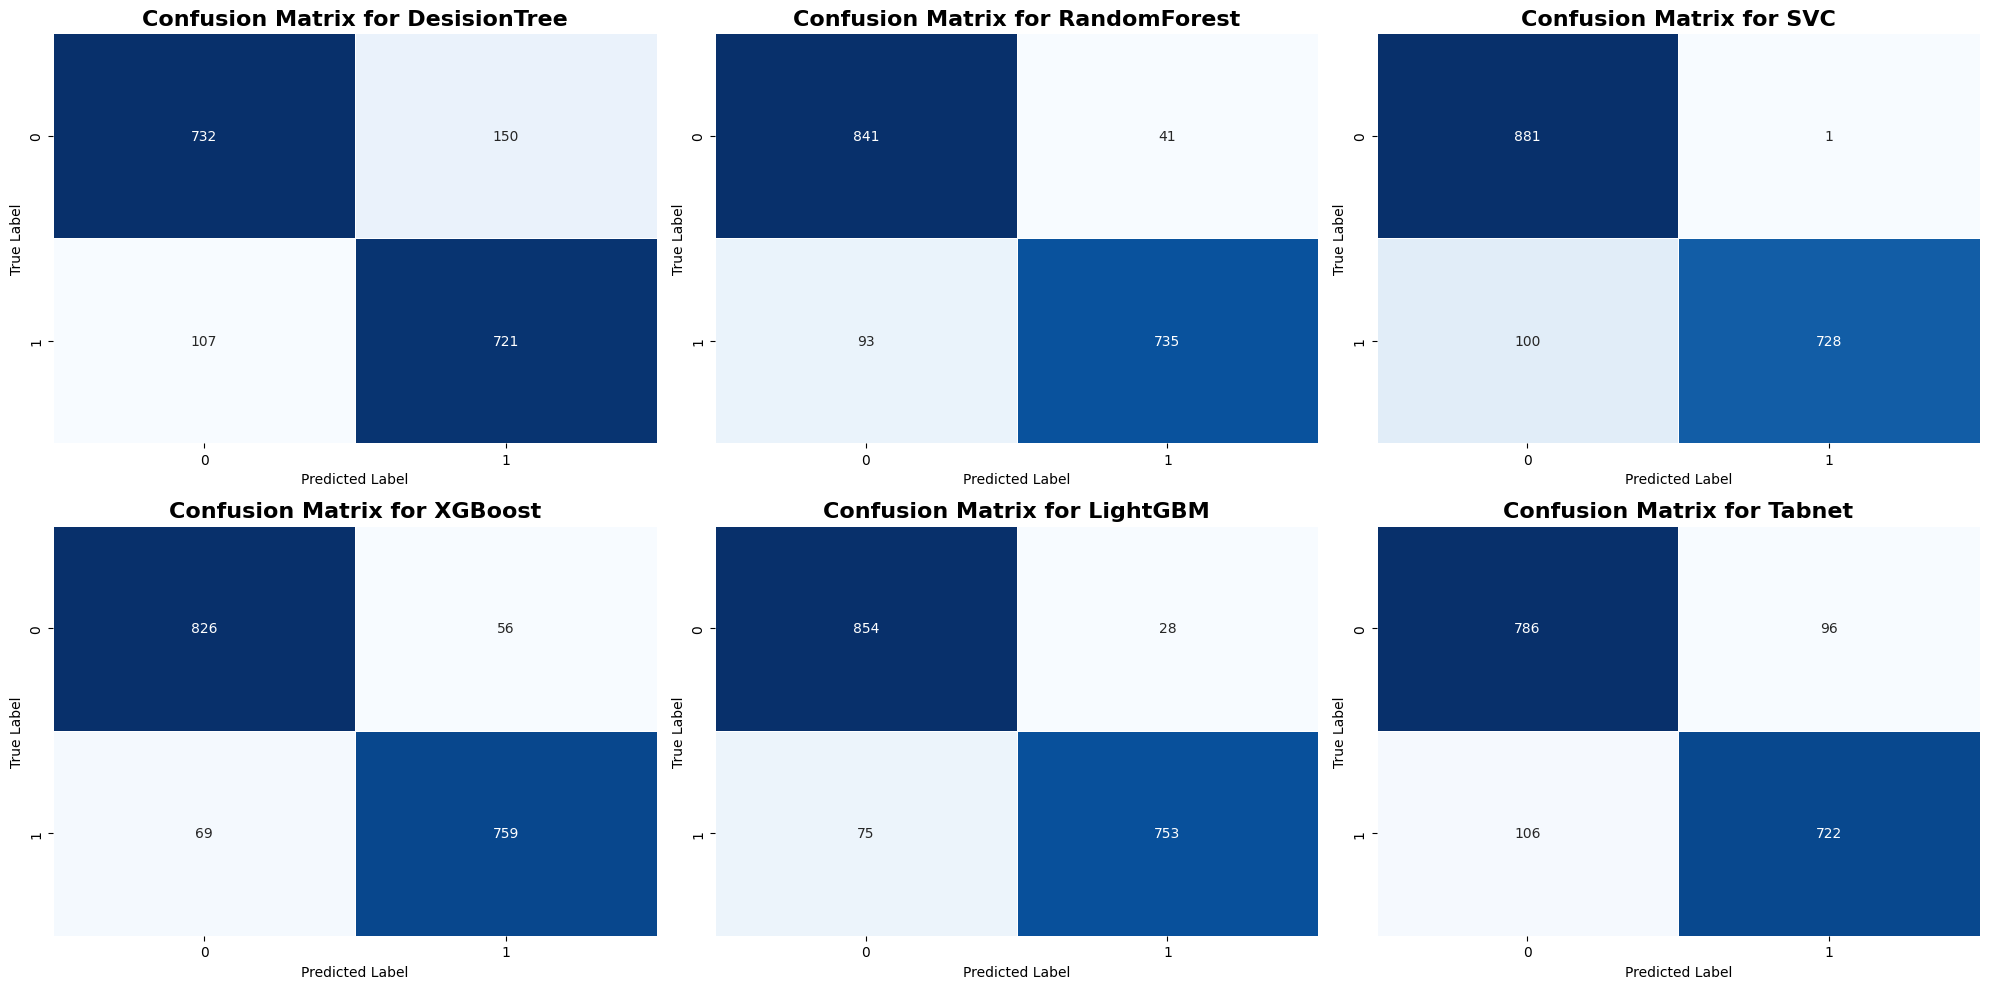

In [52]:
CM={}
for model_name,model in best_model.items():
    if model_name!='Tabnet':     
        y_pred=model.predict(X_test)
        cm = confusion_matrix(y_test, y_pred)
    else:
        y_pred=model.predict(X_test.values)
        cm = confusion_matrix(y_test.values, y_pred)
    CM[model_name]=cm


import math

# Calculate the number of rows and columns for the grid
n = len(CM)
ncols = 3
nrows = math.ceil(n / ncols)

fig, axs = plt.subplots(nrows, ncols, figsize=(20, 10))  # Create a grid of subplots
axs = axs.flatten()  # Flatten the grid to a 1D array for easy iteration

for idx, (name, cm) in enumerate(CM.items()):
    ax = axs[idx]  # Select the subplot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', linewidths=.5, cbar=False, ax=ax)  # Plot on the selected subplot
    ax.set_title(f'Confusion Matrix for {name}', fontsize=16, weight='bold')  # Set the title for the subplot
    ax.set_xlabel('Predicted Label')  # Set the x-label for the subplot
    ax.set_ylabel('True Label')  # Set the y-label for the subplot

# Remove extra subplots
for idx in range(n, nrows*ncols):
    fig.delaxes(axs[idx])

plt.tight_layout()  # Ensure the subplots do not overlap
plt.show()  # Display the plot



Roc_auc_score:0.9874133228170495


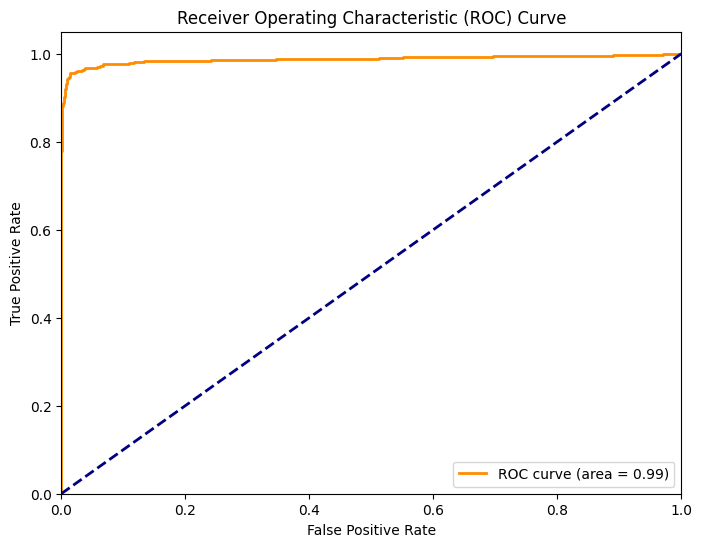

In [26]:
#ROC Curve
y_prob=best_model['SVC'].predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)

# Calculate the AUC (Area Under the Curve)
roc_auc = auc(fpr, tpr)
print(f"Roc_auc_score:{roc_auc_score(y_test, y_prob)}")
# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

Roc_auc_score for DesisionTree: 0.8503524598245096
Roc_auc_score for RandomForest: 0.9738681301828299
Roc_auc_score for SVC: 0.9874133228170495
Roc_auc_score for XGBoost: 0.9763260376614414
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Roc_auc_score for LightGBM: 0.9779596218519615
Roc_auc_score for Tabnet: 0.9540049514169598


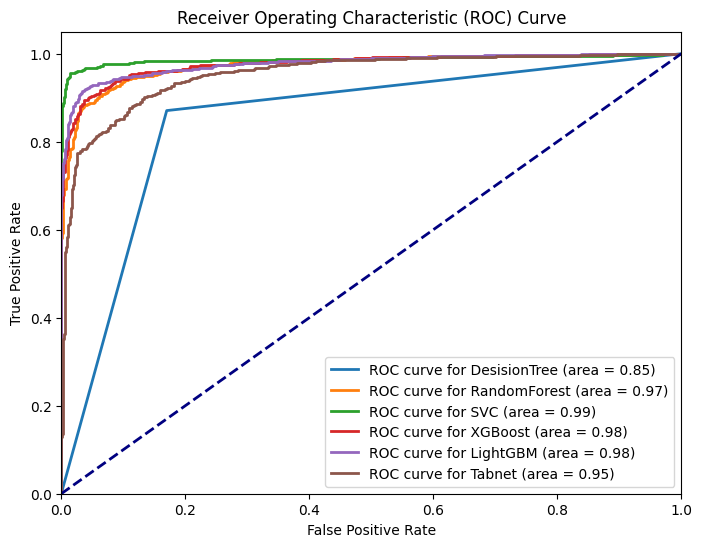

In [56]:
#ROC Curve for all the models
plt.figure(figsize=(8, 6))

# Iterate over models
for model_name, model in best_model.items():
    if model_name!='Tabnet':
        y_prob = model.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_prob)
    else:
        y_prob = model.predict_proba(X_test.values)[:,1]  # Select only the probabilities for the positive class
        fpr, tpr, thresholds = roc_curve(y_test.values, y_prob)

    # Calculate the AUC (Area Under the Curve)
    roc_auc = auc(fpr, tpr)
    print(f"Roc_auc_score for {model_name}: {roc_auc_score(y_test, y_prob)}")

    # Plot the ROC curve
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve for {model_name} (area = {roc_auc:.2f})')

# Plot the random guess line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

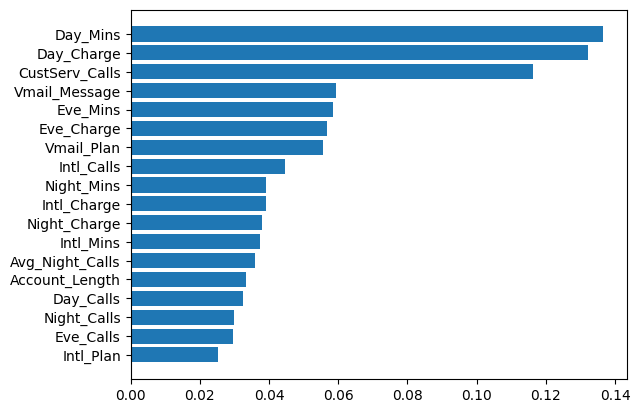

In [27]:
#checking the feature importance using Random Forest
importance=best_model['RandomForest'].feature_importances_
sorted_idx = np.argsort(importance)
plt.barh(X.columns[sorted_idx],importance[sorted_idx])
plt.show()

In [28]:
#Saving model
joblib.dump(best_model['SVC'],'Churn_classifier_SVC.joblib')


['Churn_classifier_SVC.joblib']